In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time

from PIL import Image

from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
from keras.applications.densenet import DenseNet121

from keras.layers import Input
from keras.layers import Dropout
from keras.layers.core import Dense
from keras.models import Model
from keras import backend as K
#print(dir(keras.applications.densenet.DenseNet121))

from time import time
import pickle
from pickle import dump, load
import glob
import os
from random import shuffle
import importlib
from configparser import ConfigParser

Using TensorFlow backend.


In [3]:
!pip install pydot

In [0]:
os.chdir('/content/drive/My Drive/r_r_g_project')

In [5]:
first_sent = load(open("para.pickle", "rb"))
print('Photos: train=%d' % len(first_sent))

Photos: train=3668


In [6]:
indication_sent = load(open("indication_keys.pickle", "rb"))
print('Photos: train=%d' % len(indication_sent))

Photos: train=3668


In [7]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(first_sent)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 2311


In [8]:
all_indications = set()
for key in indication_sent.keys():
    all_indications.update(indication_sent[key].split())
indicationVocab = all_indications
print('Original Vocabulary Size: %d' % len(indicationVocab))

Original Vocabulary Size: 1572


In [0]:
# Below path contains all the images
images = 'NLMCXR_png/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.png')

In [10]:
len(img)

7480

In [0]:
with open("loaded_img_names.pkl", "wb") as encoded_pickle:
     pickle.dump(img, encoded_pickle)

In [0]:
# Removing duplicate images

for _ in range(5):
  for item in img:
    if '(' in item:
      img.remove(item) 

In [13]:
[item for item in img if '(' in item]

[]

In [14]:
len(img)

7470

In [0]:
train_img_paths = img[:int(len(img)*0.70)]
valid_img_paths = img[int(len(img)*0.70): int(len(img)*0.70 + len(img)*0.20)]
test_img_paths =  img[int(len(img)*0.70 + len(img)*0.20):]

In [16]:
print("No of images for training: ", len(train_img_paths))
print("No of images for validating: ", len(valid_img_paths))
print("No of images for testing: ", len(test_img_paths))

No of images for training:  5229
No of images for validating:  1494
No of images for testing:  747


In [0]:
def get_train_valid_test_data(img):
    img = [item.split("/")[-1] for item in img]
    train_imgs = img[:int(len(img)*0.70)]
    valid_imgs = img[int(len(img)*0.70): int(len(img)*0.70 + len(img)*0.20)]
    test_imgs =  img[int(len(img)*0.70 + len(img)*0.20):]
    return train_imgs, valid_imgs, test_imgs

In [0]:
train_imgs, valid_imgs, test_imgs = get_train_valid_test_data(img)

In [0]:
weights_path = "best_weights.h5"

In [0]:
class ModelFactory:
    """
    Model facotry for Keras default models
    """

    def __init__(self):
        self.models_ = dict(
            VGG16=dict(
                input_shape=(224, 224, 3),
                module_name="vgg16",
                last_conv_layer="block5_conv3",
            ),
            VGG19=dict(
                input_shape=(224, 224, 3),
                module_name="vgg19",
                last_conv_layer="block5_conv4",
            ),
            DenseNet121=dict(
                input_shape=(224, 224, 3),
                module_name="densenet",
                last_conv_layer="bn",
            ),
            ResNet50=dict(
                input_shape=(224, 224, 3),
                module_name="resnet50",
                last_conv_layer="activation_49",
            ),
            InceptionV3=dict(
                input_shape=(299, 299, 3),
                module_name="inception_v3",
                last_conv_layer="mixed10",
            ),
            InceptionResNetV2=dict(
                input_shape=(299, 299, 3),
                module_name="inception_resnet_v2",
                last_conv_layer="conv_7b_ac",
            ),
            NASNetMobile=dict(
                input_shape=(224, 224, 3),
                module_name="nasnet",
                last_conv_layer="activation_188",
            ),
                        NASNetLarge=dict(
                input_shape=(331, 331, 3),
                module_name="nasnet",
                last_conv_layer="activation_260",
            ),
        )

    def get_last_conv_layer(self, model_name):
        return self.models_[model_name]["last_conv_layer"]

    def get_input_size(self, model_name):
        return self.models_[model_name]["input_shape"][:2]

    def get_model(self, model_name="DenseNet121", use_base_weights=True,
                  weights_path=None, input_shape=None):

        if use_base_weights is True:
            base_weights = "imagenet"
        else:
            base_weights = None

        base_model_class = getattr(
            importlib.import_module(
                f"keras.applications.{self.models_[model_name]['module_name']}"
            ),
            model_name)

        if input_shape is None:
            input_shape = self.models_[model_name]["input_shape"]

        img_input = Input(shape=input_shape)

        base_model = base_model_class(
            include_top=False,
            input_tensor=img_input,
            input_shape=input_shape,
            weights=base_weights,
            pooling="avg")
        x = base_model.output
        predictions = Dense(14, activation="sigmoid", name="predictions")(x)
        model = Model(inputs=img_input, outputs=predictions)

        if weights_path == "":
            weights_path = None
        

        if weights_path is not None:
            print(f"load model weights_path: {weights_path}")
            model.load_weights(weights_path)
        return model

In [21]:
model_factory = ModelFactory()
model = model_factory.get_model(
    use_base_weights=False,
    weights_path=weights_path)
print(model.summary())









load model weights_path: best_weights.h5
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
___________________________________________

In [0]:
def load_image(image_path):
        image = Image.open(image_path)
        image_array = np.asarray(image.convert("RGB"))
        image_array = image_array / 255.
        image_array = np.resize(image_array, (1,224,224,3))
        return image_array

In [0]:
def get_img_encoding(img):
    #img = load_image(train_img_paths[0])
    img = load_image(img)
    get_last_but_one_layer_output = K.function([model.layers[0].input],
                                        [model.layers[-2].output])
    layer_output = get_last_but_one_layer_output([img])
    return layer_output[0].squeeze()

In [0]:
sample_img_encoding = get_img_encoding(img[0])

In [25]:
sample_img_encoding.shape

(1024,)

In [0]:
# # Call the funtion to encode all the train images
# # This will take a while on CPU - Execute this only once
# start = time()
# encoding_train = {}
# for img in train_imgs:
#     encoding_train[img[len(images):]] = get_img_encoding(img)
# print("Time taken in seconds =", time()-start)

In [0]:
# len(encoding_train)

In [0]:
# import pickle
# # Save the bottleneck train features to disk
# with open("PavanPickle/encoded_train_images.pkl", "wb") as encoded_pickle:
#     pickle.dump(encoding_train, encoded_pickle)

In [0]:
# # Call the funtion to encode all the test images - Execute this only once
# start = time()
# encoding_test = {}
# for img in valid_imgs:
#     encoding_test[img[len(images):]] = get_img_encoding(img)
# print("Time taken in seconds =", time()-start)

In [0]:
# len(encoding_test)

In [0]:
# # Save the bottleneck train features to disk
# with open("PavanPickle/encoded_test_images.pkl", "wb") as encoded_pickle:
#     pickle.dump(encoding_test, encoded_pickle)

In [32]:
train_features = load(open("encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=5091


In [33]:
encoding_test = load(open("encoded_test_images.pkl", "rb"))
print('Photos: train=%d' % len(encoding_test))

Photos: train=1455


In [34]:
# Create a list of all the training captions
all_captions = []
for key, val in first_sent.items():
    for cap in val:
        all_captions.append(cap)
len(all_captions)

3668

In [35]:
# Create a list of all the training indications
all_indications = []
for key, val in indication_sent.items():
    all_indications.append(val)
len(all_indications)

3668

In [36]:
len(indication_sent)

3668

In [0]:
# load clean descriptions into memory
def load_clean_descriptions(desc, dataset):
    descriptions = dict()
    for key, val in desc.items():
        image_id, image_desc = key, val
        image_id = image_id+'.png'
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = ''.join(image_desc)
            # store
            descriptions[image_id].append(desc)
    return descriptions

In [0]:
# dataset = list()
# for img in train_imgs:
#     identifier = img[len(images):]
#     dataset.append(identifier)

In [39]:
# descriptions
train_descriptions = load_clean_descriptions(first_sent, train_imgs)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=2563


In [40]:
# descriptions
train_indications = load_clean_descriptions(indication_sent, train_imgs)
print('Descriptions: indication=%d' % len(train_indications))

Descriptions: indication=2563


In [41]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

2563

In [42]:
# Create a list of all the training captions
all_train_indications = []
for key, val in train_indications.items():
    for cap in val:
        all_train_indications.append(cap)
len(all_train_indications)

2563

In [43]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 1
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 2026 -> 2026


In [44]:
# Consider only words which occur at least 10 times in the corpus
indication_count_threshold = 1
indication_counts = {}
nsents = 0
for sent in all_train_indications:
    nsents += 1
    for w in sent.split(' '):
        indication_counts[w] = indication_counts.get(w, 0) + 1

indicationVocab = [w for w in indication_counts if indication_counts[w] >= indication_count_threshold]
print('preprocessed words %d -> %d' % (len(indication_counts), len(indicationVocab)))

preprocessed words 1293 -> 1293


In [0]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [46]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

2027

In [0]:
ixtoindicationWord = {}
indicationWordtoix = {}

ix = 1
for w in indicationVocab:
    indicationWordtoix[w] = ix
    ixtoindicationWord[ix] = w
    ix += 1

In [48]:
IndicationVocab_size = len(ixtoindicationWord) + 1 # one for appended 0's
IndicationVocab_size

1294

In [49]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 172


In [0]:
all_Indication_desc = list()
for key in train_indications.keys():
    for d in train_indications[key]:
        all_Indication_desc.append(d)

In [51]:
max_Indication_length = max(len(d.split()) for d in all_Indication_desc)
max_Indication_length

40

In [0]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, indications, wordtoix, indicationWordtoix, max_Indication_length,max_length, num_photos_per_batch):
    X1, X2, X3, y = list(), list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for indication in indications[key]:
                indicationSeq = [indicationWordtoix[word] for word in indication.split(' ') if word in indicationWordtoix]
            indicationSeq = pad_sequences([indicationSeq], maxlen=max_Indication_length)[0]
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(indicationSeq)
                    X3.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2), array(X3)], array(y)]
                X1, X2, X3, y = list(), list(), list(), list()
                n=0

In [0]:
# !pip install gensim

In [0]:
from gensim.models import KeyedVectors

In [0]:
# Required first time
# !git clone https://github.com/facebookresearch/fastText.git

In [0]:
# cd fastText

In [0]:
# pip install .

In [0]:
# word_vectors = KeyedVectors.load_word2vec_format('/content/drive/My Drive/r_r_g_project/WordEmbeddings/BioWordVec_PubMed_MIMICIII_d200.vec.bin',binary=True)

In [0]:
# medic_vector = word_vectors.get_vector('clinical')

In [0]:
# embeddings_index = {} # empty dictionary
# i = 0
# for item in word_vectors.vocab:
#     word = item
#     coefs = np.asarray(word_vectors.get_vector(word), dtype='float32')
#     embeddings_index[word] = coefs
#     i+=1
# print('Found %s word vectors.' % len(embeddings_index))

In [0]:
# embedding_dim = 200

# # Get 200-dim dense vector for each of the 10000 words in out vocabulary
# embedding_matrix = np.zeros((vocab_size, embedding_dim))

# for word, i in wordtoix.items():
#     #if i < max_words:
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         # Words not found in the embedding index will be all zeros
#         embedding_matrix[i] = embedding_vector

In [0]:


# # Get 200-dim dense vector for each of the 10000 words in out vocabulary
# indication_embedding_matrix = np.zeros((IndicationVocab_size, embedding_dim))

# for word, i in indicationWordtoix.items():
#     #if i < max_words:
#     indicationembedding_vector = embeddings_index.get(word)
#     if indicationembedding_vector is not None:
#         # Words not found in the embedding index will be all zeros
#         indication_embedding_matrix[i] = indicationembedding_vector

In [0]:
embedding_dim = 200

In [0]:
with open("/content/drive/My Drive/r_r_g_project/embedding_matrix.pkl", "rb") as encoded_pickle:
    embedding_matrix = load(encoded_pickle)

In [0]:
with open("/content/drive/My Drive/r_r_g_project/indication_embedding_matrix.pkl", "rb") as encoded_pickle:
    indication_embedding_matrix = load(encoded_pickle)

In [66]:
embedding_matrix.shape

(2029, 200)

In [67]:
indication_embedding_matrix.shape

(1292, 200)

In [0]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [0]:
IndicationVocab_size = IndicationVocab_size-2
vocab_size = vocab_size+2

In [0]:
imageFeature = Input(shape=(1024,))
indication = Input(shape=(max_Indication_length,))
indication1 = Embedding(IndicationVocab_size, embedding_dim)(indication)
indication2 = Flatten()(indication1)
imgIndi = keras.layers.concatenate([imageFeature, indication2],axis=1)
fe1 = Dropout(0.5)(imgIndi)
fe2 = Dense(256, activation='relu')(fe1)
findings = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(findings)
se2 = Dropout(0.5)(se1)
# se3 = LSTM(256, return_sequences=True,return_state=True)(se2)
# se4, hs3, cs3 = LSTM(256,return_state=True)(se3)
se3 = Bidirectional(LSTM(256, return_sequences=True))(se2)
se4 = LSTM(256)(se3)
decoder1 = add([fe2, se4])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
newModel = Model(inputs=[imageFeature, indication, findings], outputs=outputs)

In [0]:
# from keras.utils import plot_model
# plot_model(newModel, to_file='model.png')

In [0]:
# inputs1 = Input(shape=(1024,))
# fe1 = Dropout(0.5)(inputs1)
# fe2 = Dense(256, activation='relu')(fe1)
# inputs2 = Input(shape=(max_length,))
# se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
# se2 = Dropout(0.5)(se1)
# se3 = LSTM(256, return_sequences=True,return_state=True)(se2)
# se4, hs3, cs3 = LSTM(256,return_state=True)(se3)
# decoder1 = add([fe2, se4, cs3])
# decoder2 = Dense(256, activation='relu')(decoder1)
# outputs = Dense(vocab_size, activation='softmax')(decoder2)
# newModel = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [149]:
newModel.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 40, 200)      258400      input_9[0][0]                    
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 172)          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 1024)         0                                            
____________________________________________________________________________________________

In [150]:
newModel.layers[1]

In [151]:
newModel.layers[5]

In [0]:
newModel.layers[1].set_weights([indication_embedding_matrix])
newModel.layers[1].trainable = False

In [0]:
newModel.layers[5].set_weights([embedding_matrix])
newModel.layers[5].trainable = False

In [0]:
newModel.compile(loss='categorical_crossentropy', optimizer='adam')

In [0]:
newModel.optimizer.lr = 0.0001
epochs = 5
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [0]:
unmatched = []
for item in train_descriptions.keys():
  if item not in train_features.keys():
    unmatched.append(item)

In [0]:
for item in unmatched:
  del train_descriptions[item]

In [104]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features,train_indications, wordtoix, indicationWordtoix, max_Indication_length,max_length, number_pics_per_bath)
    newModel.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    newModel.save_weights('model_' + str(i) + '.h5')

Epoch 1/1
427/427 [==============================] - 542s 1s/step - loss: 5.2826
Epoch 1/1
427/427 [==============================] - 534s 1s/step - loss: 4.2555
Epoch 1/1
427/427 [==============================] - 536s 1s/step - loss: 3.7434
Epoch 1/1
427/427 [==============================] - 539s 1s/step - loss: 3.4364
Epoch 1/1
427/427 [==============================] - 541s 1s/step - loss: 3.2118


In [0]:
#newModel.save_weights('NewModel_Weights/model_10.h5')

In [0]:
newModel.load_weights('model_4.h5')

In [0]:
with open("encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [0]:
def greedySearch(photo, indication_seq):
    in_text = 'startseq'
    indication_seq = [indicationWordtoix[w] for w in indication_seq.split() if w in ixtoindicationWord]
    indication_seq = pad_sequences([indication_seq], maxlen=max_Indication_length)
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = newModel.predict([photo,indication_seq,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [128]:
z = 15
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic]
image.shape

(1024,)

In [134]:
indication_sent['CXR3533_IM-1726-1001']

'xxxx year old xxxx with shortness of breath xxxx. .'

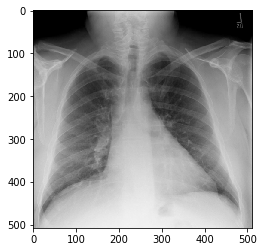

Greedy: the heart size and pulmonary vascularity are within normal limits. the lungs are clear.


In [135]:
image = get_img_encoding('NLMCXR_png/CXR3533_IM-1726-1001.png').reshape((1,1024))
x=plt.imread('NLMCXR_png/CXR3533_IM-1726-1001.png')
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image,indication_sent['CXR3533_IM-1726-1001']))

In [133]:
first_sent['CXR1973_IM-0633-1001']

['startseq cardiomediastinal silhouette is within normal limits for size with redemonstration of tortuous and atherosclerotic calcified thoracic aorta. no focal consolidation effusion or pneumothorax identified. eventration of the right hemidiaphragm is stable compared to prior examination. multilevel degenerative disc disease and thoracolumbar spine again noted without acute osseous abnormality. endseq']

In [0]:
first_sent['CXR3533_IM-1726-1001']

['startseq heart size mediastinal contour and pulmonary vascularity are within normal limits. there is bilateral hyperinflation without focal consolidation pneumothorax or pleural effusion. visualized osseous structures appear intact. endseq']

CXR3507_IM-1709-1001.png
[[2.1679570e-04 1.4706849e-03 1.3446215e-03 ... 7.4329609e-01
  8.6610430e-01 6.0427809e-01]]


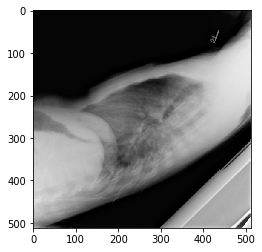

input: indication -  xxxx year old male mvc.
Greedy: the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.


In [181]:
z = 21
z+=1
pic = list(encoding_test.keys())[z]
print(pic)
image = encoding_test[pic].reshape((1,1024))
print(image)
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("input: indication - ",indication_sent[pic[:-4]])
print("Greedy:",greedySearch(image,indication_sent[pic[:-4]]))

In [0]:
for i in range(5, 5+epochs):
    generator = data_generator(train_descriptions, train_features,train_indications, wordtoix, indicationWordtoix, max_Indication_length,max_length, number_pics_per_bath)
    newModel.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    newModel.save_weights('model_' + str(i) + '.h5')

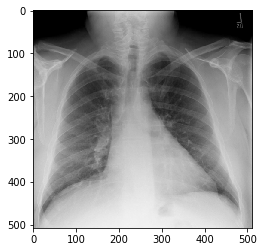

Greedy: the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.


In [174]:
image = get_img_encoding('NLMCXR_png/CXR3533_IM-1726-1001.png').reshape((1,1024))
x=plt.imread('NLMCXR_png/CXR3533_IM-1726-1001.png')
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image,indication_sent['CXR3533_IM-1726-1001']))

CXR3499_IM-1703-2002.png


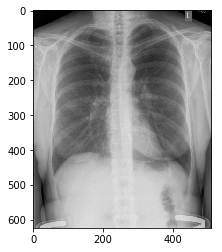

Greedy: the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.


In [166]:
z = 4
z+=1
pic = list(encoding_test.keys())[z]
print(pic)
image = encoding_test[pic].reshape((1,1024))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image,indication_sent[pic[:-4]]))

In [0]:
def beam_search_predictions(photo, beam_index = 3):
    start = [wordtoix["startseq"]]
    
    # start_word[0][0] = index of the starting word
    # start_word[0][1] = probability of the word predicted
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            e = encoding_test[photo[len(images):]]
            #preds = model.predict([np.array([e]), np.array(par_caps)])
            preds = newModel.predict([np.array([e]),np.array(par_caps)], verbose=0)
            
            # Getting the top <beam_index>(n) predictions
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # creating a new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [0]:
z = 15
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,1024))


In [145]:
print ('Beam Search, k=10:', beam_search_predictions(image, beam_index=10))

TypeError: ignored